<a href="https://colab.research.google.com/github/alexhenriquepineda/Previsao-Notas-ENEM/blob/main/TCC_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

In [ ]:
zipfile.ZipFile('/content/drive/MyDrive/TCC/datasets/enem.zip', 'r').extractall('/content/drive/MyDrive/TCC/datasets')

**0.0 IMPORTS**

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from matplotlib import pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**0.1 HELPER FUNCTION**

In [2]:
from IPython.core.display  import HTML
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [69]:
def graphic_percentage(ax,total):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height,
                '{:1.2f}'.format(height/total*100),
                ha="center") 
    show

In [3]:
def reduce_mem_usage(df):
    """
    iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    fonte: https://www.kaggle.com/valleyzw/ubiquant-lgbm-baseline  
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in tqdm([x for x in df.columns if 'NU_NOTA_' not in x]):
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

**1.0 LOADING DATA**

In [4]:
data_raw = pd.read_csv('/content/drive/MyDrive/TCC/datasets/train.csv')

In [5]:
data = reduce_mem_usage(data_raw)

Memory usage of dataframe is 2981.62 MB


100%|██████████| 113/113 [00:48<00:00,  2.33it/s]

Memory usage after optimization is: 732.86 MB
Decreased by 75.4%


**2.0 DATA DESCRIPTION**

In [6]:
df_train = data.copy()

In [7]:
colunas_dados_participante = ['NU_INSCRICAO','CO_MUNICIPIO_RESIDENCIA','NO_MUNICIPIO_RESIDENCIA','CO_UF_RESIDENCIA','SG_UF_RESIDENCIA',
                              'NU_IDADE','TP_SEXO','TP_ESTADO_CIVIL','TP_COR_RACA','TP_NACIONALIDADE','CO_MUNICIPIO_NASCIMENTO',
                              'NO_MUNICIPIO_NASCIMENTO','CO_UF_NASCIMENTO','SG_UF_NASCIMENTO','TP_ST_CONCLUSAO','TP_ANO_CONCLUIU',
                              'TP_ESCOLA','TP_ENSINO','IN_TREINEIRO']

#Features com o código da região do estado
df_train['CO_REGIAO_RESIDENCIA'] = df_train['CO_MUNICIPIO_RESIDENCIA'].astype(str).str[:3]

#Age Groups
# Criar grupos de partipantes conforme a faixa de idade
group = (0, 15, 18, 23, 36, 60, 120)
cats = ['ADOLESCENTE','ADOLESCENTE_2', 'JOVEM','JOVEM_2', 'ADULTO', 'IDOSO']
#df_train["NO_IDADE_GROUP"] = pd.cut(df_train.NU_IDADE, group, labels=cats)

colunas_dados_participante = list(set(colunas_dados_participante) - (set(colunas_dados_participante) - set(df_train.columns) ) )

# ==============================================================================

colunas_dados_escola = ['CO_ESCOLA', 'CO_MUNICIPIO_ESC','NO_MUNICIPIO_ESC','CO_UF_ESC','SG_UF_ESC','TP_DEPENDENCIA_ADM_ESC',
                        'TP_LOCALIZACAO_ESC','TP_SIT_FUNC_ESC']

colunas_dados_escola = list(set(colunas_dados_escola) - (set(colunas_dados_escola) - set(df_train.columns) ) )

# ==============================================================================

colunas_atend_especial = ['IN_BAIXA_VISAO','IN_CEGUEIRA','IN_SURDEZ','IN_DEFICIENCIA_AUDITIVA','IN_SURDO_CEGUEIRA',
                          'IN_DEFICIENCIA_FISICA','IN_DEFICIENCIA_MENTAL','IN_DEFICIT_ATENCAO','IN_DISLEXIA',
                          'IN_DISCALCULIA','IN_AUTISMO','IN_VISAO_MONOCULAR','IN_OUTRA_DEF']

colunas_atend_especial = list(set(colunas_atend_especial) - (set(colunas_atend_especial) - set(df_train.columns) ) )

#df_train["IN_ATEND_ESPECIAL"] = df_train[colunas_atend_especial].max(axis=1)

# ==============================================================================

colunas_atend_especifico = ['IN_GESTANTE','IN_LACTANTE','IN_IDOSO','IN_ESTUDA_CLASSE_HOSPITALAR']
colunas_atend_especifico = list(set(colunas_atend_especifico) - (set(colunas_atend_especifico) - set(df_train.columns) ) )

#df_train["IN_ATEND_ESPECIFICO"] = df_train[colunas_atend_especifico].max(axis=1)

# ==============================================================================

colunas_recurso_especial = ['IN_SEM_RECURSO','IN_BRAILLE','IN_AMPLIADA_24','IN_AMPLIADA_18','IN_LEDOR','IN_ACESSO',
                            'IN_TRANSCRICAO','IN_LIBRAS','IN_TEMPO_ADICIONAL','IN_LEITURA_LABIAL','IN_MESA_CADEIRA_RODAS',
                            'IN_MESA_CADEIRA_SEPARADA','IN_APOIO_PERNA','IN_GUIA_INTERPRETE','IN_COMPUTADOR','IN_CADEIRA_ESPECIAL',
                            'IN_CADEIRA_CANHOTO','IN_CADEIRA_ACOLCHOADA','IN_PROVA_DEITADO','IN_MOBILIARIO_OBESO','IN_LAMINA_OVERLAY',
                            'IN_PROTETOR_AURICULAR','IN_MEDIDOR_GLICOSE','IN_MAQUINA_BRAILE','IN_SOROBAN','IN_MARCA_PASSO','IN_SONDA',
                            'IN_MEDICAMENTOS','IN_SALA_INDIVIDUAL','IN_SALA_ESPECIAL','IN_SALA_ACOMPANHANTE','IN_MOBILIARIO_ESPECIFICO',
                            'IN_MATERIAL_ESPECIFICO','IN_NOME_SOCIAL']

colunas_recurso_especial = list(set(colunas_recurso_especial) - (set(colunas_recurso_especial) - set(df_train.columns) ) )

#df_train["IN_RECURSO_ESPECIAL"] = df_train[colunas_recurso_especial].max(axis=1)
#df_train["IN_RECURSO_ESPECIAL"] = df_train["IN_SEM_RECURSO"]

# ==============================================================================

colunas_local_prova = ['CO_MUNICIPIO_PROVA', 'NO_MUNICIPIO_PROVA','CO_UF_PROVA','SG_UF_PROVA']

colunas_local_prova = list(set(colunas_local_prova) - (set(colunas_local_prova) - set(df_train.columns) ) )

# ==============================================================================

colunas_prova_objetiva = ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT',
                          'NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_MT','TP_LINGUA']

colunas_prova_objetiva = list(set(colunas_prova_objetiva) - (set(colunas_prova_objetiva) - set(df_train.columns) ) )

# ==============================================================================

colunas_prova_redacao = ['TP_STATUS_REDACAO','NU_NOTA_REDACAO']

colunas_prova_redacao = list(set(colunas_prova_redacao) - (set(colunas_prova_redacao) - set(df_train.columns) ) )

# ==============================================================================

colunas_socio_economico = ['Q001','Q002','Q003','Q004','Q005','Q006','Q007','Q008','Q009','Q010','Q011','Q012','Q013',
                           'Q014','Q015','Q016','Q017','Q018','Q019','Q020','Q021','Q022','Q023','Q024','Q025'
]

colunas_socio_economico = list(set(colunas_socio_economico) - (set(colunas_socio_economico) - set(df_train.columns) ) )

**2.1 TAMANHO DA BASE**

In [8]:
df_train.shape

(3311925, 119)

**2.2 CHECK NA**

In [9]:
def getMissing(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count() * 100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data.sort_values(by='Total', ascending=False, inplace=True)
    print(missing_data[missing_data['Total'] > 0])

In [10]:
getMissing(df_train)

                           Total    Percent
CO_MUNICIPIO_ESC         2566547  77.494116
TP_SIT_FUNC_ESC          2566547  77.494116
TP_LOCALIZACAO_ESC       2566547  77.494116
TP_DEPENDENCIA_ADM_ESC   2566547  77.494116
SG_UF_ESC                2566547  77.494116
CO_UF_ESC                2566547  77.494116
NO_MUNICIPIO_ESC         2566547  77.494116
CO_ESCOLA                2566547  77.494116
TP_ENSINO                1441571  43.526680
NU_NOTA_MT                900794  27.198502
NU_NOTA_CN                900794  27.198502
TP_STATUS_REDACAO         762324  23.017550
NU_NOTA_REDACAO           762324  23.017550
NU_NOTA_LC                762323  23.017520
NU_NOTA_CH                762323  23.017520
CO_UF_NASCIMENTO           94562   2.855198
CO_MUNICIPIO_NASCIMENTO    94562   2.855198
SG_UF_NASCIMENTO           94562   2.855198
NO_MUNICIPIO_NASCIMENTO    94562   2.855198
NU_IDADE                      34   0.001027


In [11]:
df_train[colunas_prova_objetiva].isna().sum()

TP_LINGUA              0
TP_PRESENCA_CN         0
NU_NOTA_LC        762323
NU_NOTA_CH        762323
TP_PRESENCA_LC         0
NU_NOTA_MT        900794
NU_NOTA_CN        900794
TP_PRESENCA_CH         0
TP_PRESENCA_MT         0
dtype: int64

**3.0 DATA FILTERING**

In [12]:
df1 = df_train.copy()

**3.1 EXCLUIR ALUNOS QUE NÃO FIZERAM A PROVA OU FORAM DESCLASSIFICADOS**

In [13]:
df1 = df1.loc[(df1['TP_PRESENCA_LC'] == 1) & 
                        (df1['TP_PRESENCA_CH'] == 1) & 
                        (df1['TP_PRESENCA_MT'] == 1) & 
                        (df1['TP_PRESENCA_CN'] == 1) &
                        (df1['TP_STATUS_REDACAO'] == 1) ]

In [14]:
getMissing(df1)

                           Total    Percent
CO_MUNICIPIO_ESC         1738486  74.391778
NO_MUNICIPIO_ESC         1738486  74.391778
TP_LOCALIZACAO_ESC       1738486  74.391778
CO_ESCOLA                1738486  74.391778
TP_SIT_FUNC_ESC          1738486  74.391778
CO_UF_ESC                1738486  74.391778
TP_DEPENDENCIA_ADM_ESC   1738486  74.391778
SG_UF_ESC                1738486  74.391778
TP_ENSINO                 995451  42.596472
NO_MUNICIPIO_NASCIMENTO    66402   2.841417
CO_UF_NASCIMENTO           66402   2.841417
SG_UF_NASCIMENTO           66402   2.841417
CO_MUNICIPIO_NASCIMENTO    66402   2.841417
NU_IDADE                      29   0.001241


In [15]:
df1[colunas_prova_objetiva].isna().sum()

TP_LINGUA         0
TP_PRESENCA_CN    0
NU_NOTA_LC        0
NU_NOTA_CH        0
TP_PRESENCA_LC    0
NU_NOTA_MT        0
NU_NOTA_CN        0
TP_PRESENCA_CH    0
TP_PRESENCA_MT    0
dtype: int64

**3.2 FILTRANDO ALUNOS PELA IDADE PARA REMOVER ALGUNS OUTLIERS**

In [16]:
df1 = df1[(df1['NU_IDADE'] >= 14) & (df1['NU_IDADE'] <= 70)]

**4.0 FEATURE ENGINEERING**

In [17]:
df2 = df1.copy()

**4.1 CRIANDO VARIÁVEL MÉDIA DAS NOTAS**

In [18]:
df2['MEDIA_NOTAS'] = (df2['NU_NOTA_CH'] + df2['NU_NOTA_LC'] + df2['NU_NOTA_MT'] + df2['NU_NOTA_CN'] + df2['NU_NOTA_REDACAO']) / 5

**4.2 CRIANDO VARIÁVEL DE REGIÃO**

In [19]:
norte = ['RO', 'PA', 'AM', 'AC', 'RR', 'TO', 'AP']
sudeste = ['MG', 'SP', 'RJ', 'ES']
nordeste = ['PB', 'CE', 'PI', 'MA', 'RN', 'BA', 'AL', 'PE', 'SE'] 
sul = ['PR', 'RS', 'SC']
centrooeste = ['MS', 'DF', 'GO', 'MT']
df2['REGIAO'] = df2['SG_UF_RESIDENCIA'].apply(lambda x: 'NORTE' if x in(norte) else 'SUDESTE' if x in(sudeste) else 'NORDESTE' if x in(nordeste) else 'SUL' if x in(sul) else 'CENTRO-OESTE' if x in(centrooeste) else  0)

**5.0 EXPLORE DATA ANALYSIS**

In [20]:
df3 = df2.copy()

**5.1 ESTATÍSTICA DESCRITIVA**

In [21]:
num_attributes = df3[colunas_prova_objetiva]
cat_attributes = df3.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

Skew: mostra a deformação da sua distribuição em relação a normal

**Skew positiva:** deformação para a esquerda

**Skew negativa:** deformação para a direita

Kurtosis: mostra o quão os dados estão concentrados.

Quanto maior a kurtosis mais dados concentrados, ou seja o pico da curva será muito grande

Quanto menor a kurtosis,mais dispersos estão os dados, ou seja, o pico da curva será menor

In [22]:
#Central Tendecy - média e mediana
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersion - desvio, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

#concat
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,TP_LINGUA,0.0,1.0,1.0,0.500354,1.0,0.500000,-0.001415,-2.000000
1,TP_PRESENCA_CN,1.0,1.0,0.0,1.000000,1.0,0.000000,0.000000,0.000000
2,NU_NOTA_LC,0.0,801.7,801.7,524.325559,529.4,61.653610,-0.579255,1.302209
3,NU_NOTA_CH,0.0,835.1,835.1,511.973954,515.7,80.321952,-0.174244,0.265252
4,TP_PRESENCA_LC,1.0,1.0,0.0,1.000000,1.0,0.000000,0.000000,0.000000
5,NU_NOTA_MT,0.0,985.5,985.5,525.267284,503.9,109.257430,0.673072,-0.104045
6,NU_NOTA_CN,0.0,860.9,860.9,479.430877,472.4,76.005602,0.348700,-0.289266
7,TP_PRESENCA_CH,1.0,1.0,0.0,1.000000,1.0,0.000000,0.000000,0.000000
8,TP_PRESENCA_MT,1.0,1.0,0.0,1.000000,1.0,0.000000,0.000000,0.000000


**5.2 DADOS DOS PARTICIPANTES**

**5.2.1 Estados mais desenvolvidos têm notas maiores que estados menos desenvolvidos**

In [27]:
estados_media = df3[['SG_UF_RESIDENCIA', 'MEDIA_NOTAS']].groupby('SG_UF_RESIDENCIA').mean().sort_values('MEDIA_NOTAS', ascending=False).reset_index()

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:348: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


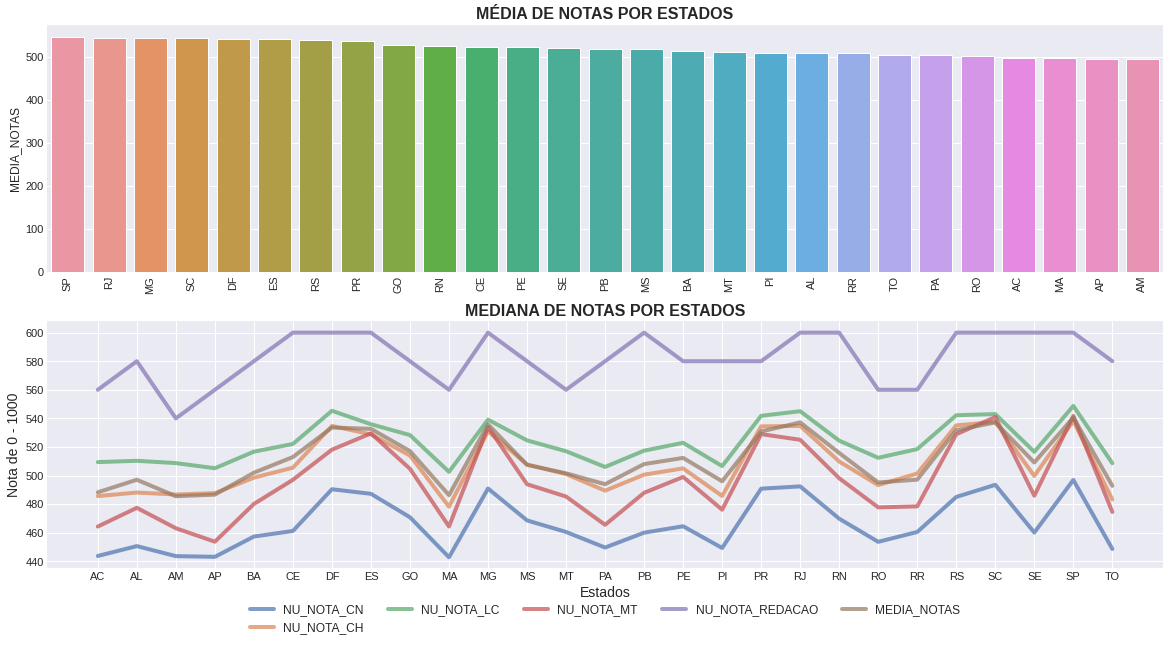

In [65]:

# Posição do Plot
plt.subplot(2, 1, 1);

# Gráfico
sns.barplot(x='SG_UF_RESIDENCIA', y='MEDIA_NOTAS', data=estados_media, order=estados_media['SG_UF_RESIDENCIA']);

# Rotacionando os labels do eixo x
plt.xticks(rotation=90);

# Apagando a legenda do eixo x
plt.xlabel('', fontsize=14 );

# Título
plt.title('MÉDIA DE NOTAS POR ESTADOS', fontsize=16, fontweight='bold');

# Analisando Residência x Notas na prova do Enem
Analise_UF = df3[['SG_UF_RESIDENCIA', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'MEDIA_NOTAS']]

# Posição do Plot
plt.subplot(2, 1, 2);

# Plot
plt.plot(Analise_UF.groupby('SG_UF_RESIDENCIA').median(), linewidth=4, alpha=0.7);

# Titulo
plt.title('MEDIANA DE NOTAS POR ESTADOS', fontsize=16, fontweight='bold');

# Labels
plt.xlabel('Estados', fontsize=14 );
plt.ylabel('Nota de 0 - 1000', fontsize=14);

# Legenda
plt.legend( ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'MEDIA_NOTAS'], 
           ncol=5, fontsize=12, loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True )

**5.2.2 A REGIÃO SUDESTE TEM AS MAIORES NOTAS**

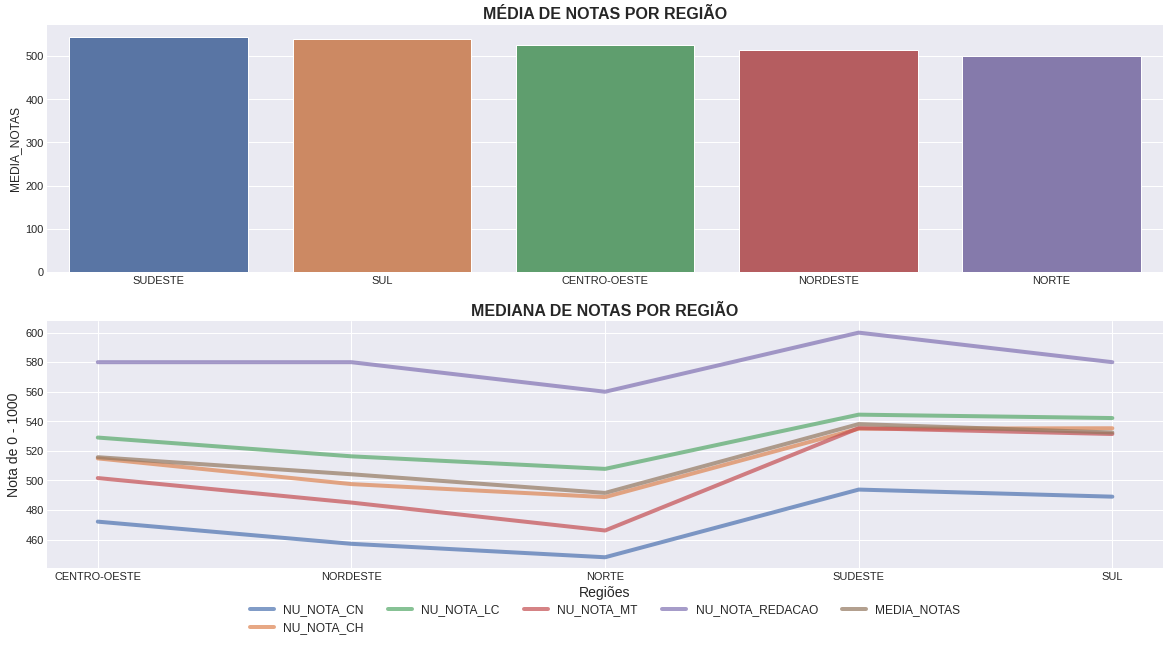

In [64]:
regiao = df3[['REGIAO', 'MEDIA_NOTAS', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_CN']].groupby('REGIAO').mean().sort_values('MEDIA_NOTAS', ascending=False).reset_index()

# Posição do Plot
plt.subplot(2, 1, 1);

# Gráfico de barras
sns.barplot(x='REGIAO', y='MEDIA_NOTAS', data=regiao, order=regiao['REGIAO']);

# Título do gráfico de barras
plt.title('MÉDIA DE NOTAS POR REGIÃO', fontsize=16, fontweight='bold');

# Removendo label do eixo X
plt.xlabel('', fontsize=14 );


# Analisando Regiões x Notas na prova do Enem
analise_regiao = df3[['REGIAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'MEDIA_NOTAS']]

# Posição do Plot
plt.subplot(2, 1, 2);

# Plot
plt.plot(analise_regiao.groupby('REGIAO').median(), linewidth=4, alpha=0.7);

# Titulo
plt.title('MEDIANA DE NOTAS POR REGIÃO', fontsize=16, fontweight='bold');

# Labels
plt.xlabel('Regiões', fontsize=14 );
plt.ylabel('Nota de 0 - 1000', fontsize=14);

# Legenda
plt.legend( ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'MEDIA_NOTAS'], 
           ncol=5, fontsize=12, loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True )

**5.2.3 JOVENS DE 17 A 22 ANOS TEM AS MAIORES NOTAS**

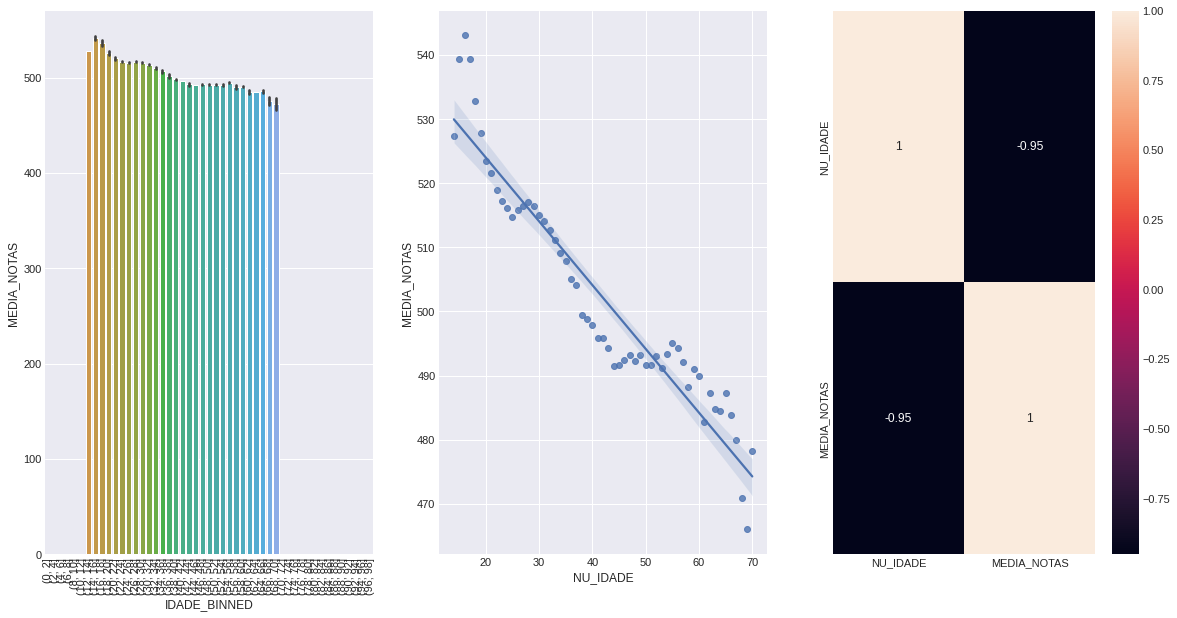

In [68]:
aux = df3[['NU_IDADE', 'MEDIA_NOTAS']].groupby('NU_IDADE').mean().reset_index()

# Agrupando as idades
bins = list(np.arange(0, 100, 2))
aux['IDADE_BINNED'] = pd.cut( aux['NU_IDADE'], bins=bins)


# Posição do gráfico
plt.subplot(1, 3, 1)
# Gráfico de barras
sns.barplot(x='IDADE_BINNED', y='MEDIA_NOTAS', data=aux);
# Rotacionando os labels do gráfico de barras
plt.xticks(rotation=90);

# Posição do gráfico 2
plt.subplot(1, 3, 2)
# Gráfico do meio
sns.regplot(x='NU_IDADE', y='MEDIA_NOTAS', data=aux);

# Posição do gráfico 3
plt.subplot(1, 3, 3)
# Gráfico de correlação
sns.heatmap(aux.corr(method='pearson'), annot=True);

**5.2.4 MULHERES TEM NOTAS MAIS ALTAS QUE HOMENS**

**HIPÓTESE FALSA:** em média os homens tem notas mais altas que as mulheres, exceto na redação

In [73]:
aux = df3[['TP_SEXO', 'MEDIA_NOTAS', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']].groupby('TP_SEXO').mean().reset_index()
aux

,TP_SEXO,MEDIA_NOTAS,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
0,F,521.992881,471.390616,506.157406,523.190665,507.881093,601.344626
1,M,535.779884,491.302473,520.562196,526.001251,550.938320,590.095180


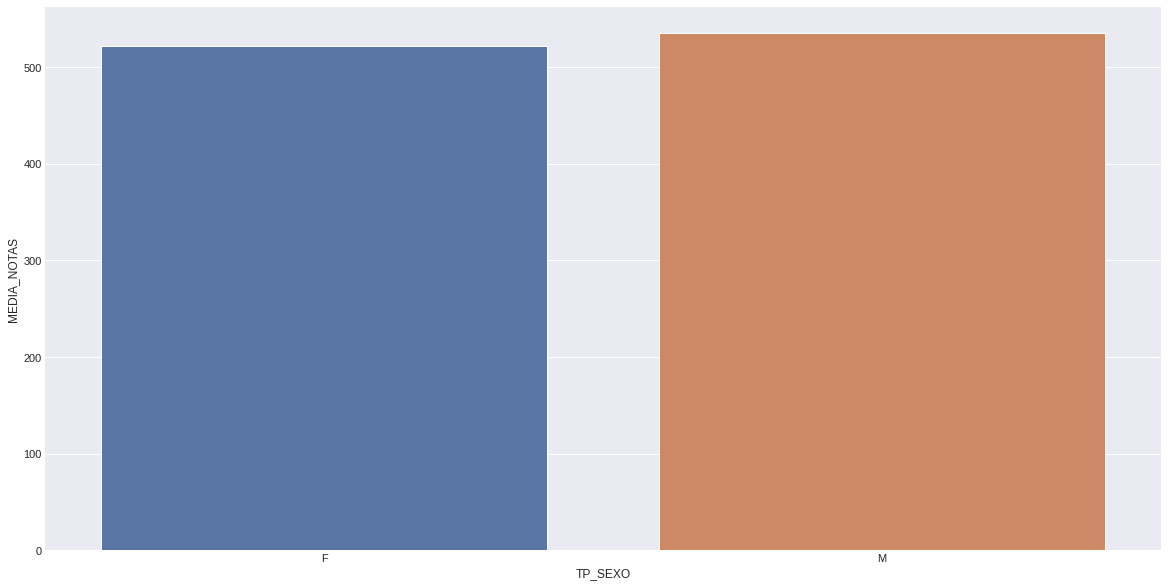

In [74]:
sns.barplot(x='TP_SEXO', y='MEDIA_NOTAS', data=aux);

**5.2.5 Devido ao racismo estrutural, os brancos têm maiores notas**

   TP_COR_RACA  MEDIA_NOTAS
0            1       546.50
1            0       525.86
2            4       513.84
3            3       503.46
4            2       500.70
5            5       476.42


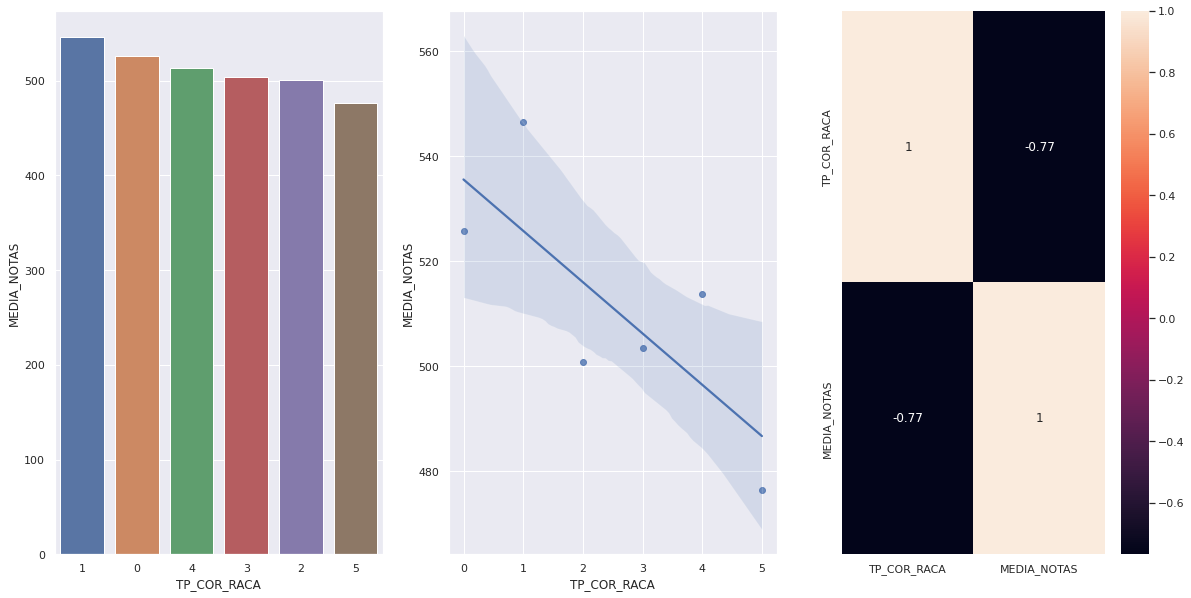

In [41]:
aux = df3[['TP_COR_RACA', 'MEDIA_NOTAS']].groupby('TP_COR_RACA').median().sort_values('MEDIA_NOTAS', ascending=False).reset_index()
print(aux)
plt.subplot(1, 3, 1)
sns.barplot(x='TP_COR_RACA', y='MEDIA_NOTAS', data=aux, order=aux['TP_COR_RACA']);
# 0 = NÃO DECLARADO
# 1 = BRANCA
# 2 = PRETA
# 3 = PARDA
# 4 = AMARELA
# 5 = INDÍGENA

plt.subplot(1, 3, 2)
sns.regplot(x='TP_COR_RACA', y='MEDIA_NOTAS', data=aux);

plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True);

**5.2.6 Quanto mais distante a formação do ensino médio, menor a nota**

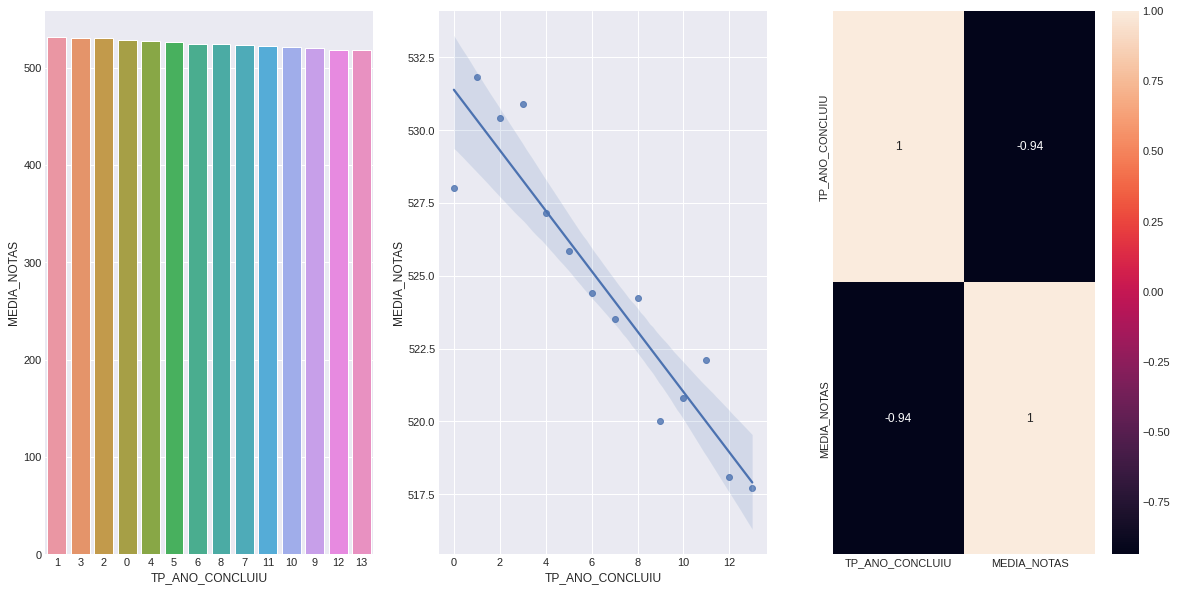

In [66]:
aux = df3[['TP_ANO_CONCLUIU', 'MEDIA_NOTAS']].groupby('TP_ANO_CONCLUIU').mean().sort_values('MEDIA_NOTAS', ascending=False).reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='TP_ANO_CONCLUIU', y='MEDIA_NOTAS', data=aux, order=aux['TP_ANO_CONCLUIU']);

plt.subplot(1, 3, 2)
sns.regplot(x='TP_ANO_CONCLUIU', y='MEDIA_NOTAS', data=aux);

plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True);

**5.2.6 Alunos de escolas particulares tem notas mais altas**

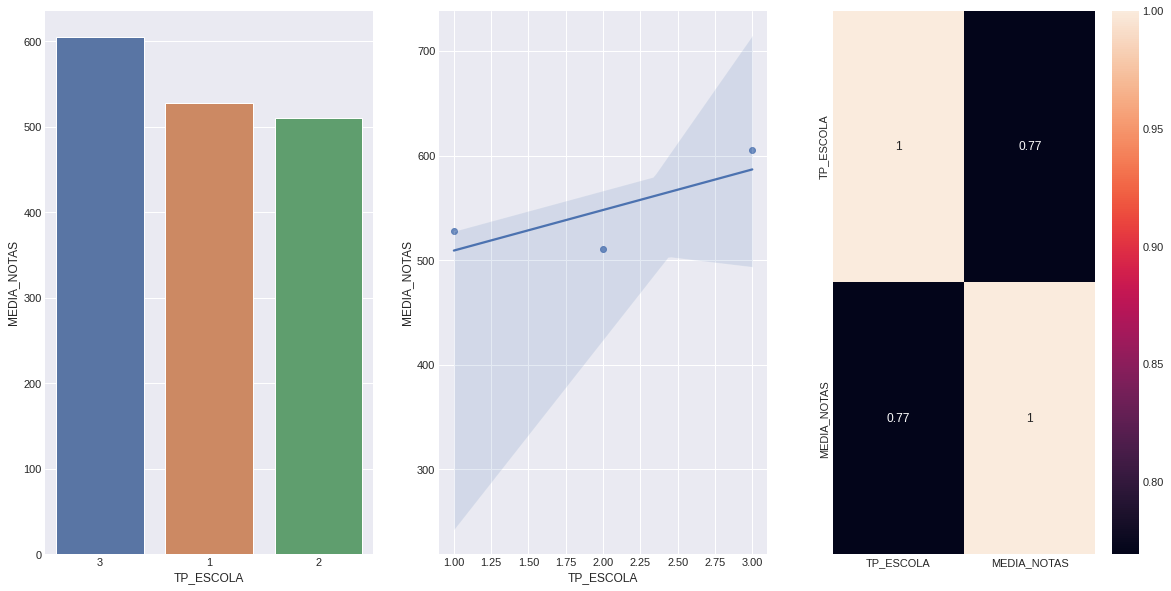

In [67]:
aux = df3[['TP_ESCOLA', 'MEDIA_NOTAS']].groupby('TP_ESCOLA').mean().sort_values('MEDIA_NOTAS', ascending=False).reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='TP_ESCOLA', y='MEDIA_NOTAS', data=aux, order=aux['TP_ESCOLA']);
#1: Não Respondeu
#2:Pública
#3:Privada

plt.subplot(1, 3, 2)
sns.regplot(x='TP_ESCOLA', y='MEDIA_NOTAS', data=aux);

plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True);